In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import copy
import seaborn as sns
from pathlib import Path

In [25]:
path = Path().cwd()
dataPath = path / "data" / "HR_data.csv" #path.parent

data = pd.read_csv(dataPath)
set(data.dtypes)

data.sort_values(['Cohort', 'Round', 'Phase', 'Individual'], inplace=True)
data.reset_index(drop=True, inplace=True)

cohort_to_session = {
    'D1_1': 'D11',  # Winter
    'D1_2': 'D12',  # Fall
    'D1_3': 'D13',  # Fall
    'D1_4': 'D13',  # Fall
    'D1_5': 'D13',  # Fall
    'D1_6': 'D13',  # Fall
}

# Create a new column
data['Session'] = data['Cohort'].map(cohort_to_session)


cohort_to_timeCompleted = {
    'D1_1': 'Unknown',  # Winter
    'D1_2': 'Unknown',  # Fall
    'D1_3': 'Morning',  # Fall
    'D1_4': 'Evening',  # Fall
    'D1_5': 'Morning',  # Fall
    'D1_6': 'Evening',  # Fall
}

data['TimeCompleted'] = data['Cohort'].map(cohort_to_timeCompleted)

In [26]:
signal_features = [
    'HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
    'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
    'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
    'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
    'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
    'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
    'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
    'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
    'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
    'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
    'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
    'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
    'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
    'EDA_TD_P_RT', 'EDA_TD_P_ReT'
]

mood_features = [
    'Frustrated', 'upset', 'hostile', 'alert','ashamed', 'inspired',
    'nervous', 'attentive', 'afraid', 'active','determined'
]

experiment_cols = ['Cohort', 'Round', 'Phase', 'Individual', 'Puzzler', 'Session', 'TimeCompleted']

In [27]:
# Import Data
Data = copy.copy(data[experiment_cols + signal_features + mood_features])
Data = Data.dropna()
Data.reset_index(drop=True)
# Data[signal_features] = Data[signal_features].fillna(Data[signal_features].mean())
# Data[mood_features] = Data[mood_features].fillna(Data[mood_features].median())

# Flip negative columns (this way, higher number -> positive semantic meaning)
flip_list = ['Frustrated','upset','hostile','ashamed','nervous','afraid']
ten_list = ['Frustrated']

flip = True
if flip:
    new_columns = {}
    for col in mood_features:
        if col in ten_list:
            Data[col] = Data[col].values/2
        if col in flip_list:
            print(f'{col} is flipped')
            new_columns[col] = col + '_flip'
            Data[col] = 5-Data[col]
    Data.rename(columns=new_columns, inplace=True)
    # mood_features_flipped = [new_columns[col] if col in flip_list else col for col in mood_features]
    mood_features = [new_columns[col] if col in flip_list else col for col in mood_features]

# Normalize within Cohort
Normalize_group = True

def normalize_by_group(df, group_col, method='zscore'):
    df_normalized = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns
    if method == 'zscore':
        func = lambda x: (x - x.mean()) / x.std()
    elif method == 'submean':
        func = lambda x: (x - x.mean())
    elif method == 'minmax':
        func = lambda x: (x - x.min()) / (x.max() - x.min())
    else:
        raise ValueError("Unsupported method. Use 'zscore' or 'minmax'.")
    df_normalized[numeric_cols] = df.groupby(group_col)[numeric_cols].transform(func)
    return df_normalized

if Normalize_group:
    Data[signal_features] = normalize_by_group(Data[signal_features], Data['Cohort'])
    # Data_results = normalize_by_group(Data_results, Data_type['Cohort'], method='zscore')

Data['mean_mood'] = Data[mood_features].mean(axis=1)
Data['min_mood'] = Data[mood_features].min(axis=1)
Data['max_mood'] = Data[mood_features].max(axis=1)

mood_features = mood_features + ['mean_mood', 'min_mood', 'max_mood']


Frustrated is flipped
upset is flipped
hostile is flipped
ashamed is flipped
nervous is flipped
afraid is flipped


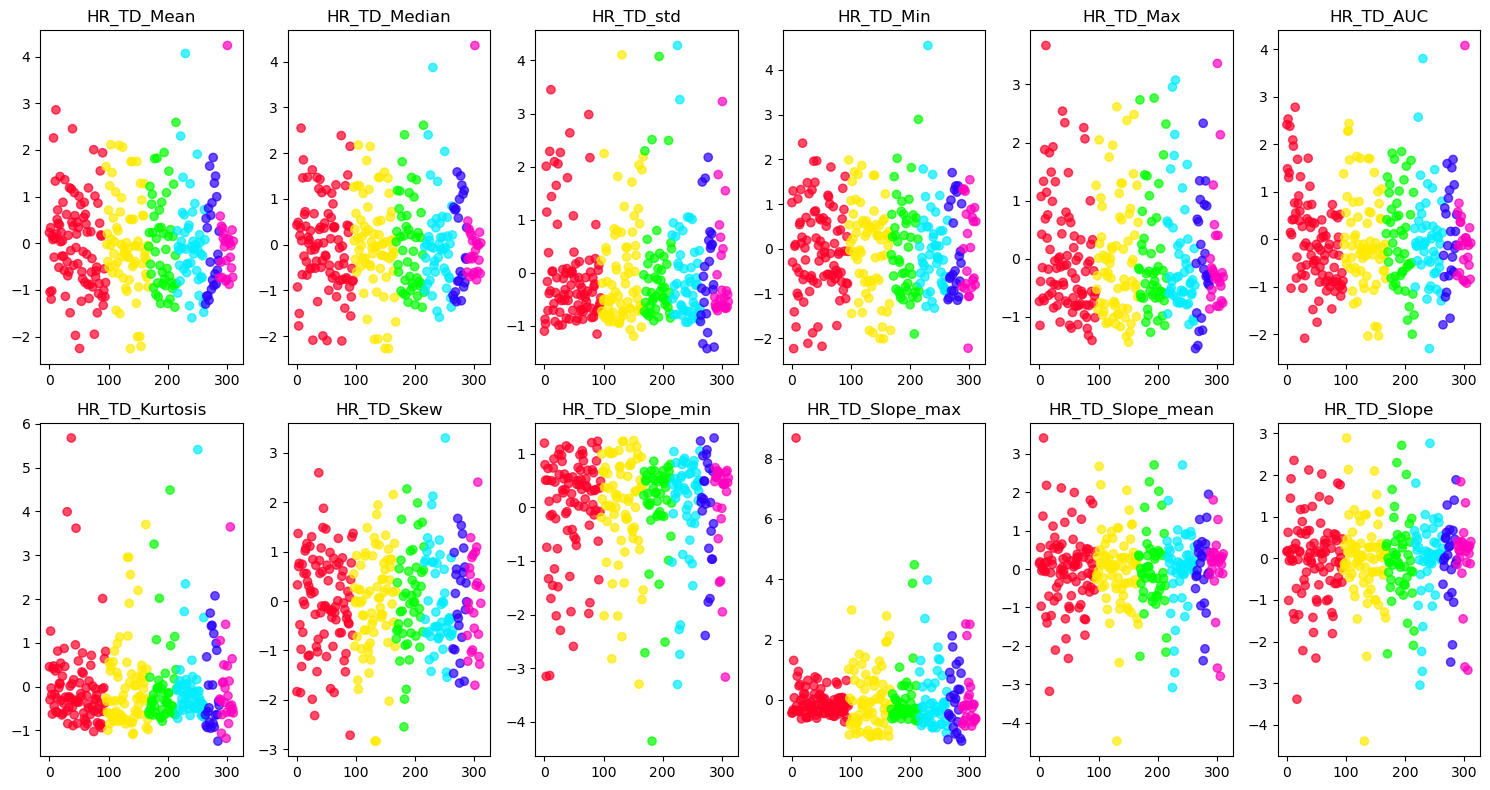

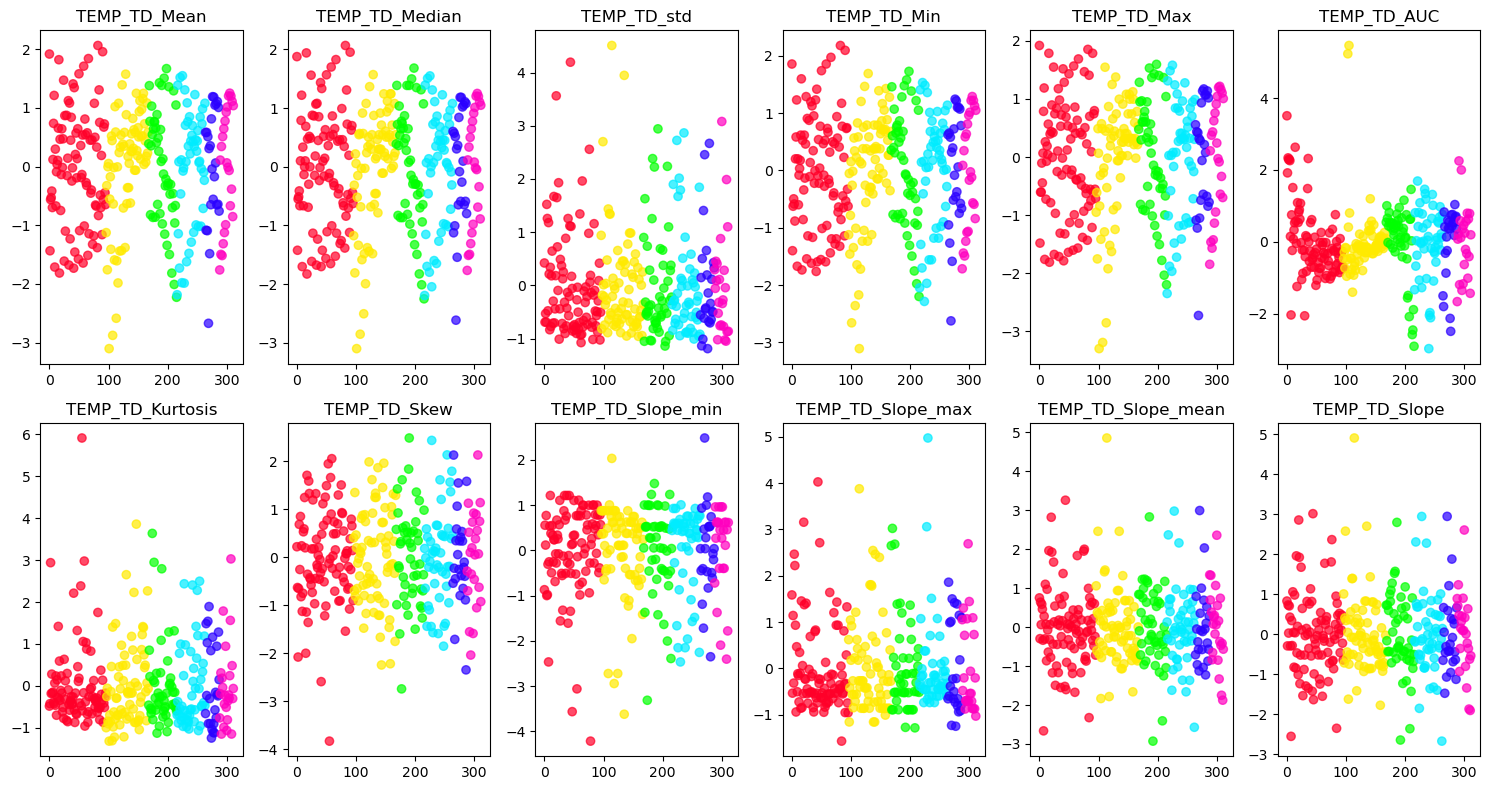

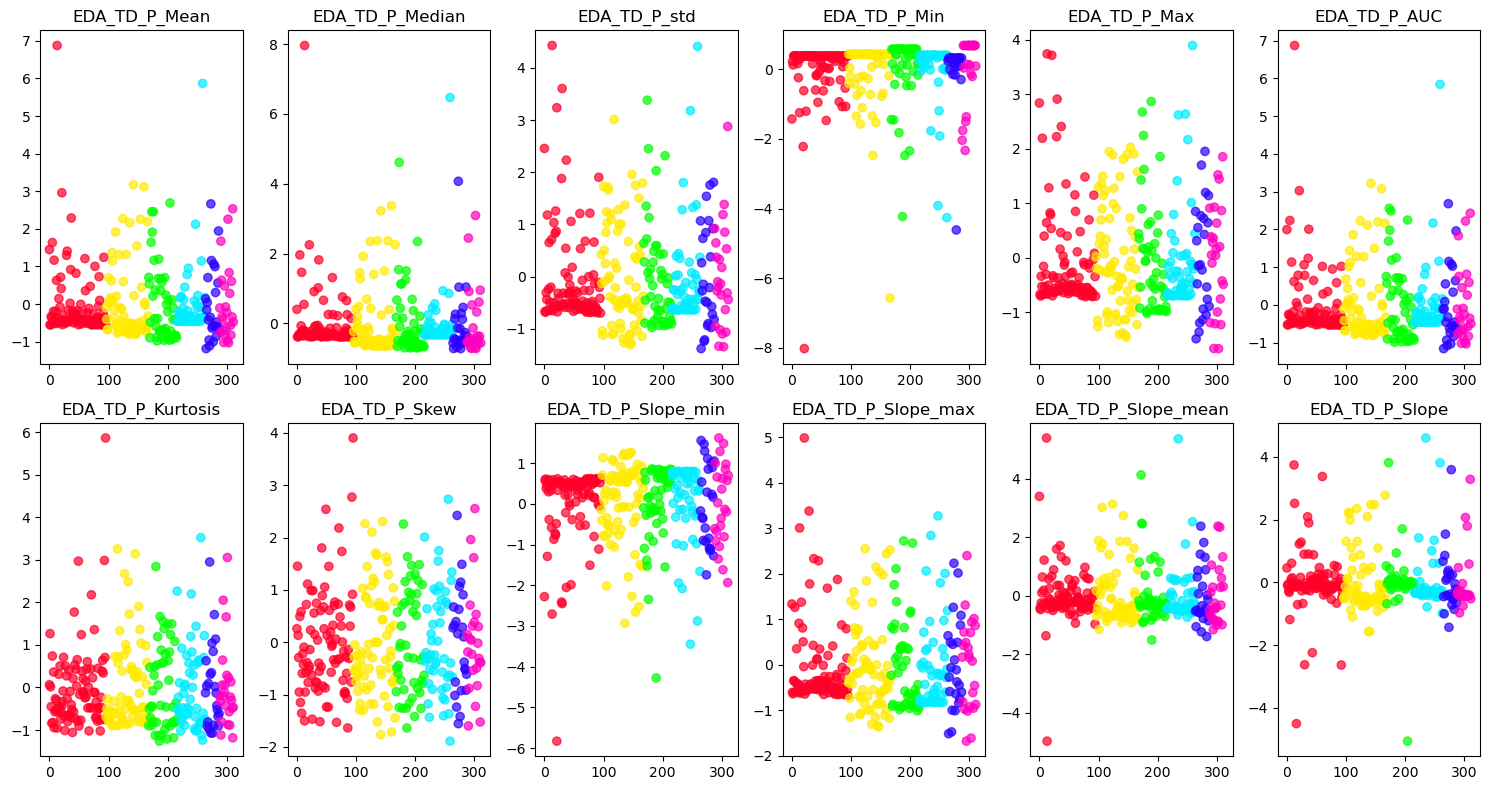

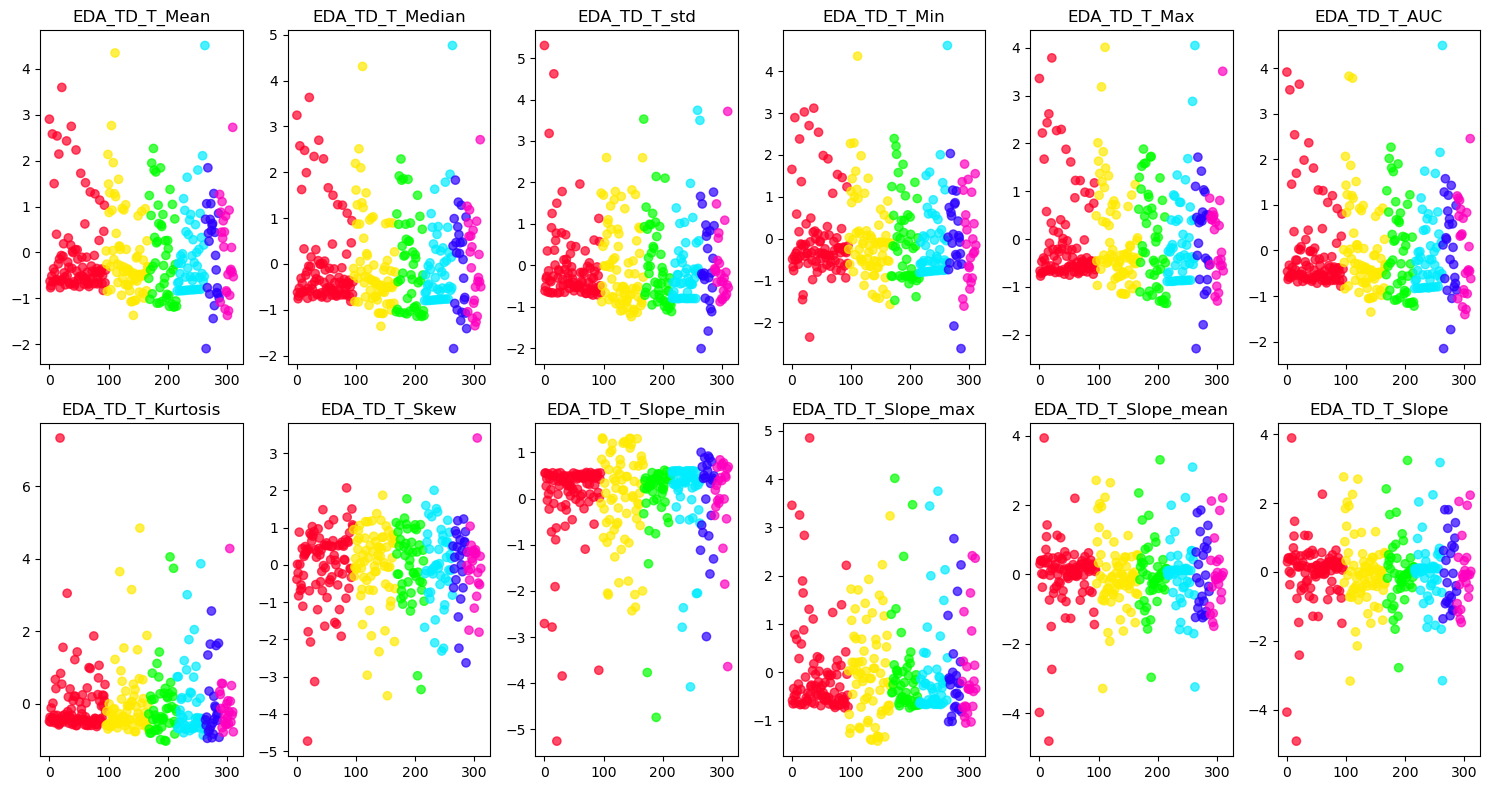

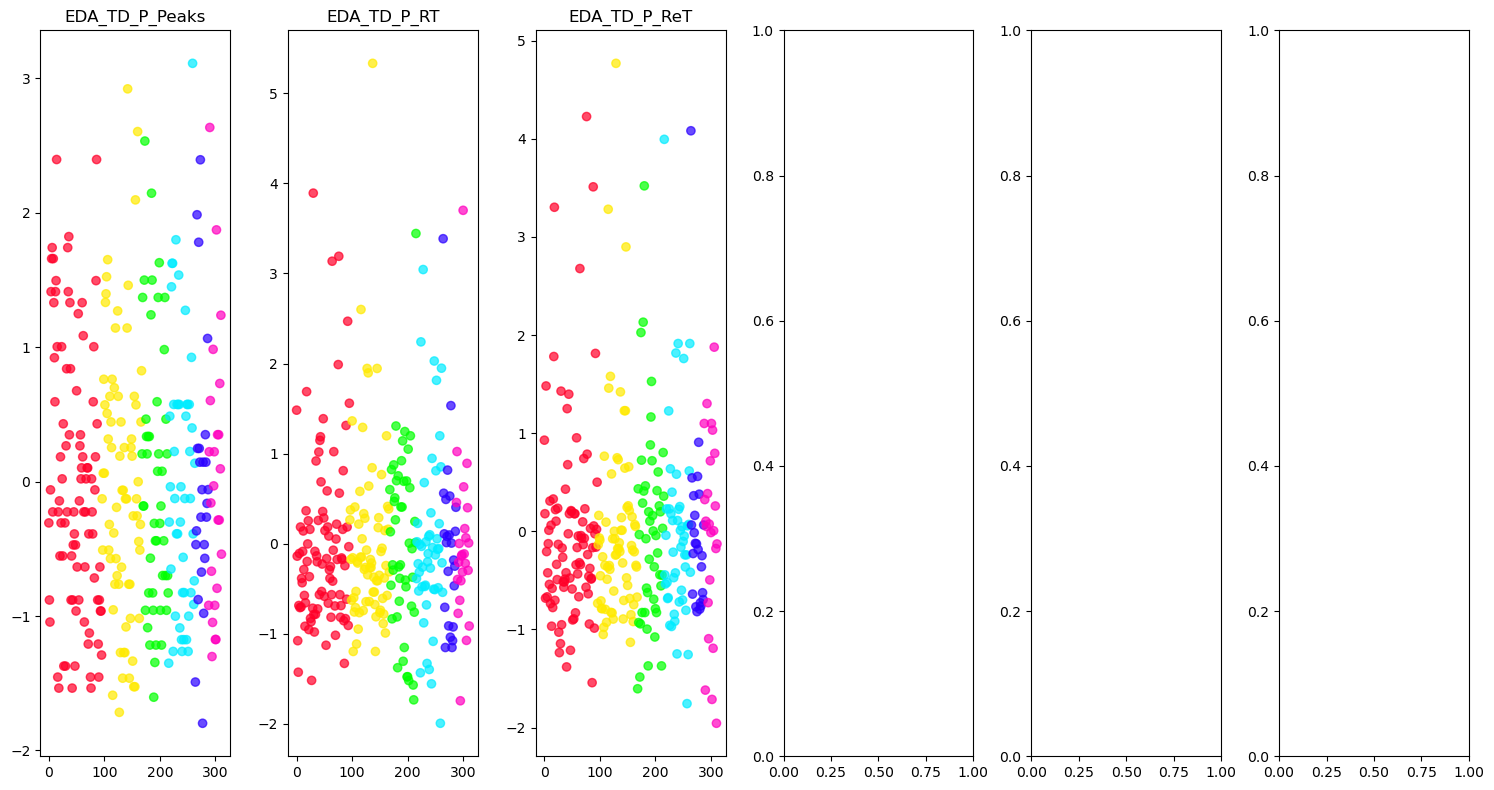

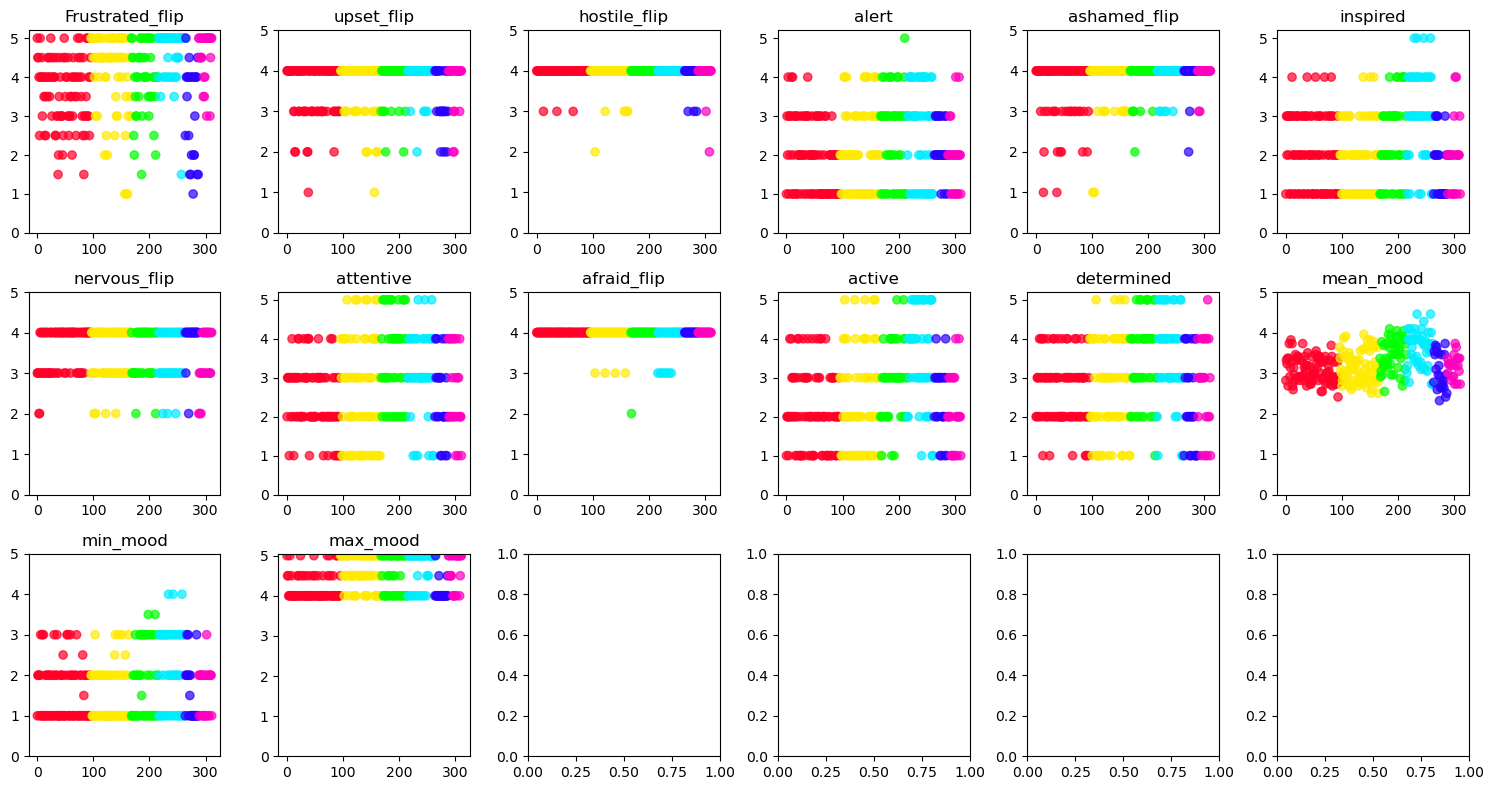

In [5]:
import math
def plotstuff(data,c,fix=False):
    num_cols = 6
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns) / num_cols), ncols=num_cols, figsize=(15, 8)) 
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        ax = axes[i]
        
        scatter = ax.scatter(
            data.index, 
            data[col], 
            c = c,
            cmap='gist_rainbow',
            alpha=0.7
        )
        
        ax.set_title(col)
        if fix:
            ax.set_yticks(range(0, 6))

    plt.tight_layout()
    plt.show()

HR = range(0,12)
TEMP = range(12,24)
EDA_P = range(24,36)
EDA_T = range(36,48)
EDA_Rest = range(48,51)


'''plotstuff:
plot a dataframe colored by fx cohort or round
    example use:
--  plotstuff(Data_results.iloc[:,HR],c=Data_type['Cohort'])
->  plot data_results (HR colums) colored by cohort
'''
cohort_codes, cohort_labels = pd.factorize(Data['Cohort'])
plotstuff(Data[signal_features].iloc[:,HR], c=cohort_codes)
plotstuff(Data[signal_features].iloc[:,TEMP], c=cohort_codes)
plotstuff(Data[signal_features].iloc[:,EDA_P], c=cohort_codes)
plotstuff(Data[signal_features].iloc[:,EDA_T], c=cohort_codes)
plotstuff(Data[signal_features].iloc[:,EDA_Rest], c=cohort_codes)

# plotstuff(Data_mean_results.iloc[:,TEMP],c=Data_type['Cohort'].values)

plotstuff(Data[mood_features], c=cohort_codes,fix=True)


#### Plotly

In [6]:
import plotly.express as px
import pandas as pd

In [7]:
Data_answers.iloc[:2]

NameError: name 'Data_answers' is not defined

In [ ]:
df = Data_answers.iloc[:]

df = df[df['Puzzler'] == 0]
df = df.iloc[:,2:]

# Build list of dimensions manually with forced ranges
dimensions = []
for col in df.columns:
    max_val = df[col].max()
    if max_val <= 5:  
        if col in ['inspired','attentive','active','determined']: 
            dimensions.append({'range': [5, 0],'label': col,'values': df[col]})
        else:
            dimensions.append({'range': [0, 5],'label': col,'values': df[col]})
    elif max_val <=10:
        dimensions.append({'range': [0, 10],'label': col,'values': df[col]})


# Create parallel coordinates plot
fig = px.parallel_coordinates(
    df,
    color="Frustrated",
    color_continuous_scale=px.colors.diverging.Tealrose
)

# Override the default dimensions with our forced ranges
fig.update_traces(dimensions=dimensions)
fig.show()


### PCA

In [28]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import Isomap

import seaborn as sns

In [29]:
# Copied from exercise solutions (w9_ex3)
def opt_k_from_gap_statistic(X, clustersNr, Nsim, plot=False):
    # clustersNr = 10
    list_of_clusters = range(1,clustersNr + 1)
    # Nsim = 20
    
    [N, p] = X.shape
    minX = list(np.min(X, axis=0)) # data range min
    maxX = list(np.max(X, axis=0)) # data range max
    Wu = np.zeros((clustersNr, Nsim))
    W = np.zeros(clustersNr)
    for nrClusters in list_of_clusters: # Want actual number included
        kmeans = KMeans(n_clusters=nrClusters, random_state=42).fit(X)
        C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
        labelCluster = kmeans.labels_ # the labelling for each point
        
        # Compute within-class dissimilarity given X (the data), C (the cluster centers)
        # and gr (the predicted cluster numbers)
        for cluster in range(1, nrClusters + 1):
            Ik = np.where(labelCluster == cluster - 1)[0]
            dk = np.sum((X[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
            Dk = np.sum(dk)
            W[nrClusters-1] += Dk
        
        
        # gap-statistic
        # Nsim simulations of data uniformly distributed over [X]
        # sim_seed = np.arange(Nsim)
        sim_seed = np.random.randint(1, 3000000, size=Nsim)
        for j in range(Nsim):
            # simulate uniformly distributed data
            Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
            # perform K-means
            kmeansU = KMeans(n_clusters=nrClusters, random_state=sim_seed[j]).fit(Xu)
            Cu = kmeansU.cluster_centers_
            labelClusterU = kmeansU.labels_

            # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
            # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
            # for the simulated data).
            for cluster in range(1, nrClusters+1):
                Iku = np.where(labelClusterU == cluster - 1)
                dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
                Dku = np.sum(dku)
                Wu[nrClusters - 1, j] += Dku
            
    # compute expectation of simulated within-class dissimilarities, and the 
    # standard errors for the error bars
    Elog_Wu = np.mean(np.log(Wu), axis = 1)
    sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
    x_range = np.array(range(nrClusters)) + 1
    
    Gk =  Elog_Wu.T - np.log(W)


    # Implementation of the rule for estimating K*, see ESL (14.39), p. 519
    K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

    if plot:


        # 5) Plot panels: within-class and gap statistic
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        plt.rcParams.update({'font.size': 12})

        # Within-class dissimilarity
        ax1.plot(list_of_clusters, np.log(W), 'o-', label='Observed log W')
        ax1.plot(list_of_clusters, Elog_Wu, 's--', label='Expected log W (null)')
        ax1.set_title('Within-class dissimilarity', fontsize = 18)

        ax1.set_xlabel('Number of clusters – k', fontsize = 15)
        ax1.set_ylabel('log(W)', fontsize = 15)
        ax1.legend(loc='best', fontsize = 13)

        # Gap statistic with error bars
        ax2.errorbar(list_of_clusters, Gk, yerr=sk, fmt='o-', capsize=5, label='Gap(k) ± sₖ')
        ax2.axvline(K_opt[1], linestyle='--', color='red', label=f'Optimal K = {K_opt[1]}')
        ax2.set_title('Gap statistic', fontsize = 18)
        ax2.set_xlabel('Number of clusters – k', fontsize = 15)
        ax2.set_ylabel('Gap(k)', fontsize = 15)
        ax2.legend(loc='best', fontsize = 13)

        fig.tight_layout()
        plt.show()


        
    
    

    if not K_opt.size:
        K_opt = clustersNr
        print ("Gap-statistic, optimal K = %d" % K_opt)
        return K_opt
    else:    
        print ("Gap-statistic, optimal K = %d" % list_of_clusters[K_opt[0]])
        return list_of_clusters[K_opt[0]]

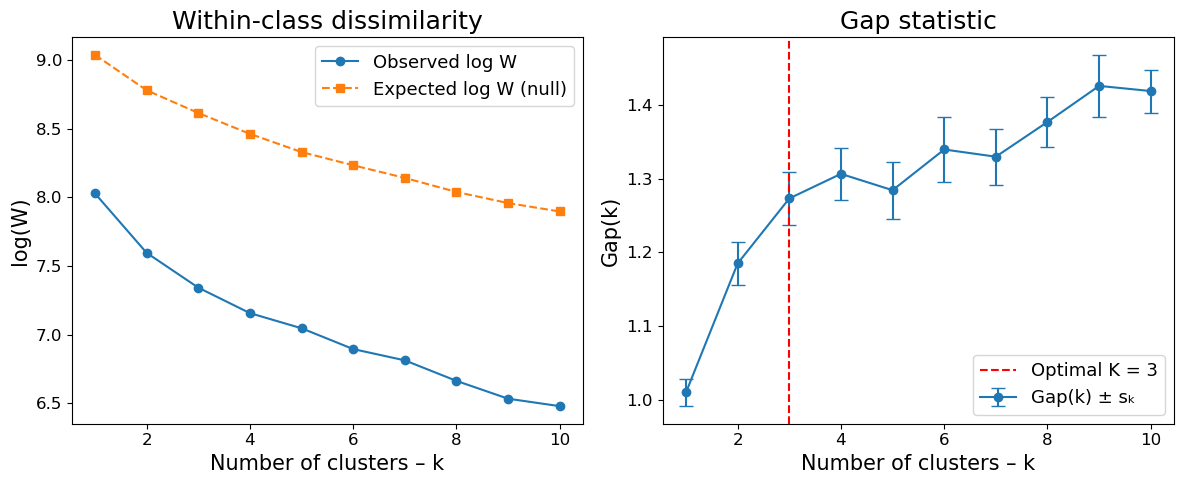

Gap-statistic, optimal K = 3
(307,)


4

In [30]:
def get_latent_dim_and_clusters(Data, feature_cols, group_col='Round', dimension_reduction_model=PCA(n_components=4)):
    
    if group_col is None:
        Data['temp_group'] = np.ones(len(Data))
    else:
        Data['temp_group'] = Data[group_col]
    grouped_dfs = []
    pca_loadings = {}
    for group_id, group_df in Data.groupby('temp_group'):
        X = group_df[feature_cols]
        X_scaled = StandardScaler().fit_transform(X)
        
        X_pca = dimension_reduction_model.fit_transform(X_scaled)
        if isinstance(dim_reduction_model, Isomap):
            latent_dim = dim_reduction_model.embedding_.shape[1]
        elif isinstance(dim_reduction_model, (PCA, TruncatedSVD)):
            latent_dim = dim_reduction_model.components_.shape[0]
        # pca = PCA(n_components=pca_n_components)
        
        components = dimension_reduction_model.components_[:2, :].T
    
        pca_loadings[group_id] = pd.DataFrame(
            components,
            index=feature_cols,
            columns=[f'PC1_{group_id}', f'PC2_{group_id}']
        )

        K_opt = opt_k_from_gap_statistic(X_pca, clustersNr=10, Nsim=20, plot = True)
        cluster = KMeans(n_clusters=K_opt, random_state=42)
        # cluster = AgglomerativeClustering()
        cluster_labels = cluster.fit_predict(X_pca)
        
        g_df = group_df.copy()
        for i in range(latent_dim):
            g_df[f'PCA_{i+1}'] = X_pca[:, i]
        g_df['cluster'] = [f'cluster {c+1}' for c in cluster_labels]
        
        print(X_pca[:, i].shape)
        g_df = g_df.drop(columns='temp_group')
        grouped_dfs.append(g_df)
    Data = Data.drop(columns='temp_group')
    return pd.concat(grouped_dfs), latent_dim, pd.concat(pca_loadings.values(), axis=1)

Data['round_phase'] = Data['Round'].astype(str).str.replace('round_', 'r') + '_' + Data['Phase'].astype(str).str.replace('phase', 'p')

# dim_reduction_model = TruncatedSVD(n_components=4)
# dim_reduction_model = Isomap(n_neighbors=10, n_components=4)   # Isomap is weird in its shapes because it operates on number of data points and not features (kernel based method)
dim_reduction_model = PCA(n_components=4)

group_col_pca = None                    # Columns to group PCA on (None means do PCA on all feat_col_pca, 'Round' means split data by Round and do PCA on all groups independently)
group_col_visualize = 'round_phase'           # Grouping col to do the visualization on (Typically equal to group_col_pca unless it is None)
# group_col = None
feat_cols_pca = mood_features           # Features to do PCA on
feat_cols_visualize = mood_features     # Features to display in visualization plots

# Data_test = data[signal_features+mood_features + ['Round' , 'Individual' ,'Puzzler']].dropna()
# Data_test['Round'] = np.ones(len(Data))
grouped_dfs, latent_dim, pca_loadings = get_latent_dim_and_clusters(Data,
                                                                    feature_cols=feat_cols_pca,
                                                                    group_col=group_col_pca,
                                                                    dimension_reduction_model=dim_reduction_model)


latent_dim

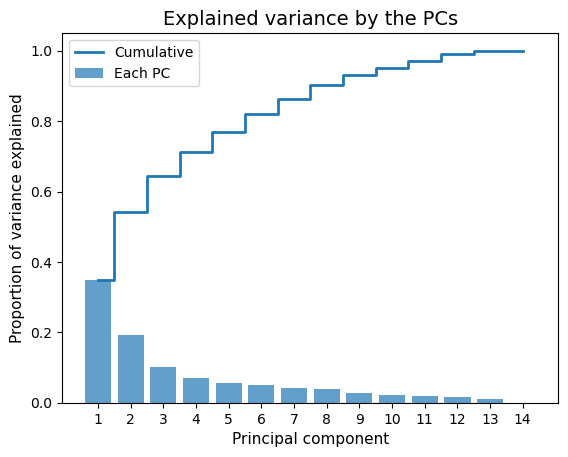

[0.34975505 0.54308958 0.64413355 0.71344053 0.76870613 0.82033174
 0.86293008 0.90317373 0.93053091 0.95224881 0.9717453  0.98941215
 1.         1.        ]


In [53]:
# explained by each PC
evr        = dim_reduction_model.explained_variance_ratio_ 
cum_evr    = np.cumsum(evr) 


# Scree / explained‑variance plot
fig, ax = plt.subplots()
pc_idx  = np.arange(1, len(evr)+1)

ax.bar(pc_idx, evr, alpha=0.7, label='Each PC')
ax.step(pc_idx, cum_evr, where='mid', label='Cumulative', linewidth=2)

ax.set_xlabel('Principal component', fontsize = 11)
ax.set_ylabel('Proportion of variance explained', fontsize = 11)
ax.set_xticks(pc_idx)
ax.set_ylim(0, 1.05)
ax.legend()
ax.set_title('Explained variance by the PCs', fontsize = 14)

plt.show()

print(cum_evr)

In [45]:
0.76870613-0.71344053

0.055265600000000026

In [ ]:
grouped_dfs

Cohort    Round   Phase  Individual  Puzzler Session TimeCompleted  \
0     D1_1  round_1  phase1           7        1     D11       Unknown   
1     D1_1  round_1  phase1           8        0     D11       Unknown   
2     D1_1  round_1  phase1           9        1     D11       Unknown   
3     D1_1  round_1  phase1          10        1     D11       Unknown   
4     D1_1  round_1  phase1          11        0     D11       Unknown   
..     ...      ...     ...         ...      ...     ...           ...   
307   D1_6  round_4  phase1           6        1     D13       Evening   
308   D1_6  round_4  phase2           5        0     D13       Evening   
309   D1_6  round_4  phase2           6        1     D13       Evening   
310   D1_6  round_4  phase3           5        0     D13       Evening   
311   D1_6  round_4  phase3           6        1     D13       Evening   

     HR_TD_Mean  HR_TD_Median  HR_TD_std  ...  determined  mean_mood  \
0      0.230204      0.429260  -1.101536  ...         2.0   2.818182   
1     -1.043429     -0.926122  -0.877660  ...         2.0   3.318182   
2      0.334967      0.485793  -0.963807  ...         3.0   3.227273   
3     -1.197033     -1.776238   2.006662  ...         3.0   3.363636   
4     -1.020007     -1.505586   1.142459  ...         3.0   2.681818   
..          ...           ...        ...  ...         ...        ...   
307   -0.051982     -0.013681  -0.674445  ...         2.0   3.181818   
308   -0.527220     -0.339006  -0.343838  ...         4.0   3.363636   
309    0.285567      0.272271  -0.646264  ...         2.0   3.045455   
310   -0.727811     -0.631521  -0.410707  ...         3.0   3.363636   
311    0.046849      0.038310  -0.546523  ...         1.0   2.727273   

     min_mood  max_mood  round_phase     PCA_1     PCA_2     PCA_3     PCA_4  \
0         1.0       5.0        r1_p1 -2.279836  1.533631 -1.515704 -0.099231   
1         2.0       4.5        r1_p1  0.503056  0.672707 -0.473166  0.631772   
2         2.0       4.5        r1_p1  0.077233  0.716620 -0.640274  0.381619   
3         2.0       4.0        r1_p1  1.203103 -0.458691 -0.952691  1.358105   
4         1.0       4.0        r1_p1 -1.954725 -0.718162 -0.835034  1.000572   
..        ...       ...          ...       ...       ...       ...       ...   
307       2.0       5.0        r4_p1 -0.617819  1.780777 -0.096597 -0.181577   
308       2.0       4.0        r4_p2  1.905414 -4.250387 -0.969400 -5.725878   
309       2.0       4.5        r4_p2 -0.767240  0.786994 -0.654102  0.545471   
310       2.0       5.0        r4_p3  0.245848  1.858797  0.107063 -0.250373   
311       1.0       5.0        r4_p3 -3.189503  1.931778 -0.497002 -0.338024   

       cluster  
0    cluster 1  
1    cluster 1  
2    cluster 1  
3    cluster 3  
4    cluster 1  
..         ...  
307  cluster 1  
308  cluster 4  
309  cluster 1  
310  cluster 1  
311  cluster 1  

[307 rows x 78 columns]

In [ ]:
dim_reduction_model.components_.shape[0]

4

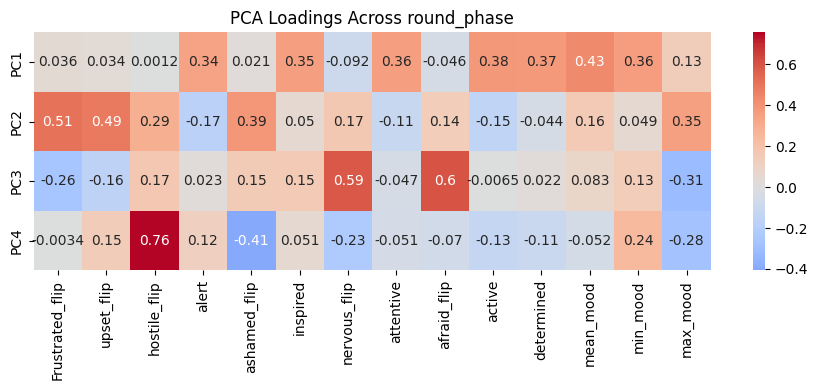

In [ ]:
pca_loading_index = [f'PC{i+1}' for i in range(dim_reduction_model.components_.shape[0])]
pca_loadings = pd.DataFrame(dim_reduction_model.components_, columns=feat_cols_pca, index=pca_loading_index).T
# evens = [i for i in range(pca_loadings.shape[1]) if (i%2)==0]
# odds = [i for i in range(pca_loadings.shape[1]) if (i%2)==1]
# pca_loadings = pca_loadings.iloc[:, evens+odds]
plt.figure(figsize=(9, 4))
sns.heatmap(pca_loadings.T, annot=True, cmap='coolwarm', center=0)
plt.title(f"PCA Loadings Across {group_col_visualize}")
plt.tight_layout()
plt.show()

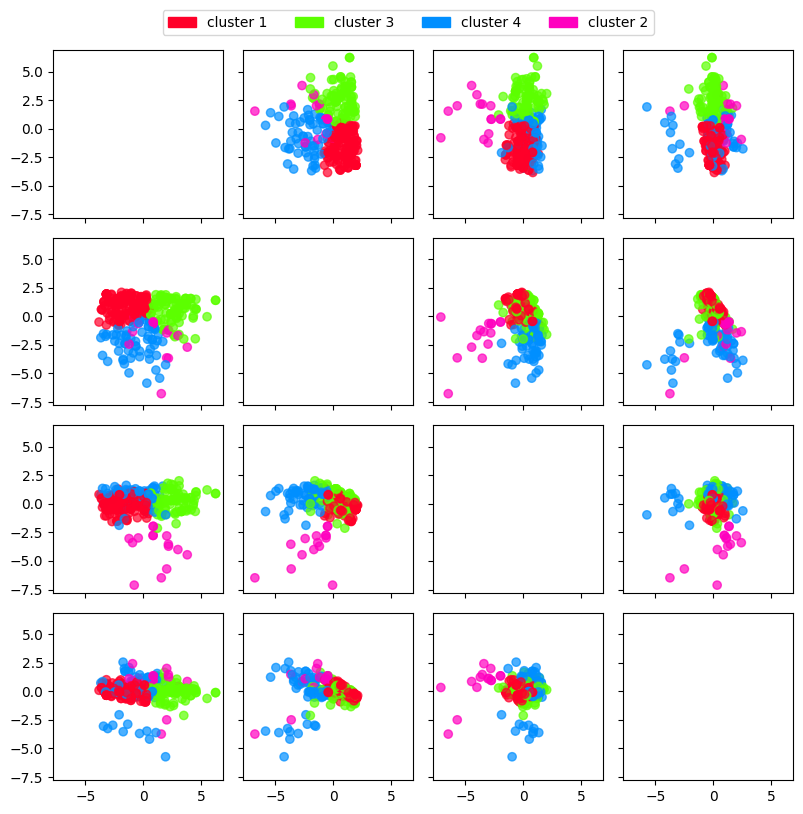

In [ ]:
signal_pca = grouped_dfs[[f'PCA_{i+1}' for i in range(latent_dim)]].values
cohort_codes, cohort_labels = pd.factorize(grouped_dfs['cluster'])


# cohort_codes, cohort_labels = pd.factorize(Data.loc[mask, 'Round'].sort_values())
fig, axs = plt.subplots(nrows=latent_dim, ncols=latent_dim, figsize=(8, 8), sharex=True, sharey=True)

# Scatter or histogram
for i in range(latent_dim):
    for j in range(latent_dim):
        ax = axs[i, j]
        pci = signal_pca[:, i]
        pcj = signal_pca[:, j]
        if i == j:
            # ax.hist(pci, color='gray', bins=30)
            pass
        else:
            sc = ax.scatter(pcj, pci, c=cohort_codes, alpha=0.7, cmap='gist_rainbow')
        # ax.set_xticks([])
        # ax.set_yticks([])

# Build manual legend
unique_codes = sorted(set(cohort_codes))
# We'll manually map code -> label (assuming label list hasn't been reordered)
label_map = {code: str(label) for code, label in enumerate(cohort_labels)}
# label_map[2] = 'Combined Cohorts'  # If you re-labeled 2–5 to 2, customize this
legend_handles = [Patch(color=plt.cm.gist_rainbow(code / max(unique_codes)), label=label_map[code])
                  for code in unique_codes]

# Add shared legend
fig.legend(handles=legend_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend
plt.show()


In [ ]:
grouped_dfs

Cohort    Round   Phase  Individual  Puzzler Session TimeCompleted  \
0     D1_1  round_1  phase1           7        1     D11       Unknown   
1     D1_1  round_1  phase1           8        0     D11       Unknown   
2     D1_1  round_1  phase1           9        1     D11       Unknown   
3     D1_1  round_1  phase1          10        1     D11       Unknown   
4     D1_1  round_1  phase1          11        0     D11       Unknown   
..     ...      ...     ...         ...      ...     ...           ...   
263   D1_4  round_4  phase3           4        0     D13       Evening   
286   D1_5  round_4  phase3          25        0     D13       Morning   
287   D1_5  round_4  phase3          26        1     D13       Morning   
310   D1_6  round_4  phase3           5        0     D13       Evening   
311   D1_6  round_4  phase3           6        1     D13       Evening   

     HR_TD_Mean  HR_TD_Median  HR_TD_std  ...  determined  mean_mood  \
0      0.230204      0.429260  -1.101536  ...         2.0   1.181818   
1     -1.043429     -0.926122  -0.877660  ...         2.0   1.818182   
2      0.334967      0.485793  -0.963807  ...         3.0   1.727273   
3     -1.197033     -1.776238   2.006662  ...         3.0   2.181818   
4     -1.020007     -1.505586   1.142459  ...         3.0   1.909091   
..          ...           ...        ...  ...         ...        ...   
263    0.075573      0.211209  -0.678790  ...         3.0   1.818182   
286   -0.370918     -0.317678  -0.227098  ...         1.0   1.272727   
287    0.257207      0.373960  -1.401532  ...         1.0   1.818182   
310   -0.727811     -0.631521  -0.410707  ...         3.0   1.545455   
311    0.046849      0.038310  -0.546523  ...         1.0   0.909091   

     min_mood  max_mood  round_phase     PCA_1     PCA_2     PCA_3     PCA_4  \
0         0.0       2.0        r1_p1 -2.178126  0.212879  0.325415 -0.189587   
1         1.0       3.0        r1_p1  0.493666 -0.323904 -0.780657 -0.125275   
2         1.0       3.0        r1_p1 -0.024674 -0.016496 -0.337257 -0.020847   
3         1.0       4.0        r1_p1  1.221276 -0.073823 -1.871257 -0.663875   
4         1.0       5.0        r1_p1 -1.865579 -1.257040 -3.209666 -0.345737   
..        ...       ...          ...       ...       ...       ...       ...   
263       0.0       3.0        r4_p3  3.075965 -0.809253 -0.084605  0.375193   
286       1.0       2.0        r4_p3 -0.538954 -0.925566 -0.572473  0.188611   
287       1.0       7.0        r4_p3 -1.664596  1.317962  1.986841 -2.240577   
310       0.0       3.0        r4_p3  1.531927 -0.490180 -0.721224  0.501081   
311       0.0       1.0        r4_p3 -2.015164 -0.900957 -1.136846  0.331748   

     cluster  
0          0  
1          0  
2          0  
3          0  
4          0  
..       ...  
263        0  
286        0  
287        0  
310        0  
311        0  

[307 rows x 78 columns]

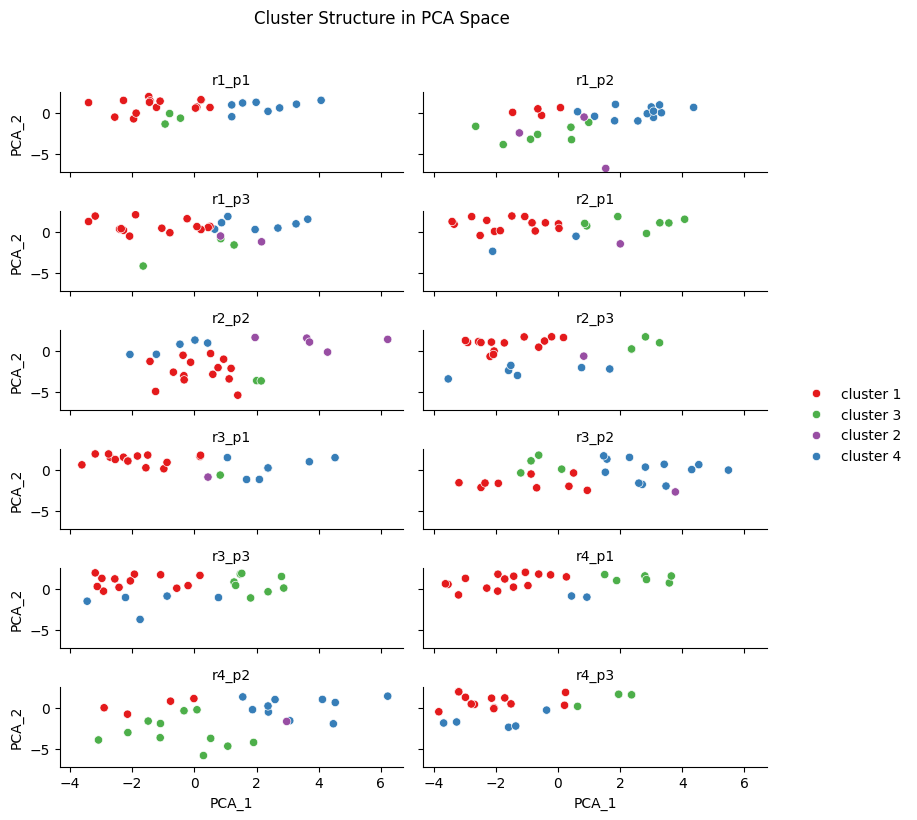

In [ ]:
g = sns.FacetGrid(grouped_dfs, col=group_col_visualize, col_wrap=2, height=4, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x='PCA_1', y='PCA_2', hue='cluster', palette='Set1')
g.add_legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
g.set_titles("{col_name}")
g.fig.set_size_inches(8, 8)
plt.suptitle("Cluster Structure in PCA Space", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
grouped_dfs

Cohort    Round   Phase  Individual  Puzzler Session TimeCompleted  \
0     D1_1  round_1  phase1           7        1     D11       Unknown   
1     D1_1  round_1  phase1           8        0     D11       Unknown   
2     D1_1  round_1  phase1           9        1     D11       Unknown   
3     D1_1  round_1  phase1          10        1     D11       Unknown   
4     D1_1  round_1  phase1          11        0     D11       Unknown   
..     ...      ...     ...         ...      ...     ...           ...   
263   D1_4  round_4  phase3           4        0     D13       Evening   
286   D1_5  round_4  phase3          25        0     D13       Morning   
287   D1_5  round_4  phase3          26        1     D13       Morning   
310   D1_6  round_4  phase3           5        0     D13       Evening   
311   D1_6  round_4  phase3           6        1     D13       Evening   

     HR_TD_Mean  HR_TD_Median  HR_TD_std  ...  afraid  active  determined  \
0      0.230204      0.429260  -1.101536  ...     1.0     1.0         2.0   
1     -1.043429     -0.926122  -0.877660  ...     1.0     2.0         2.0   
2      0.334967      0.485793  -0.963807  ...     1.0     2.0         3.0   
3     -1.197033     -1.776238   2.006662  ...     1.0     2.0         3.0   
4     -1.020007     -1.505586   1.142459  ...     1.0     1.0         3.0   
..          ...           ...        ...  ...     ...     ...         ...   
263    0.075573      0.211209  -0.678790  ...     1.0     3.0         3.0   
286   -0.370918     -0.317678  -0.227098  ...     1.0     1.0         1.0   
287    0.257207      0.373960  -1.401532  ...     1.0     2.0         1.0   
310   -0.727811     -0.631521  -0.410707  ...     1.0     2.0         3.0   
311    0.046849      0.038310  -0.546523  ...     1.0     1.0         1.0   

     mean_mood  min_mood  max_mood  round_phase     PCA_1     PCA_2  cluster  
0     1.181818       0.0       2.0        r1_p1 -2.178126  0.212879        0  
1     1.818182       1.0       3.0        r1_p1  0.493666 -0.323904        0  
2     1.727273       1.0       3.0        r1_p1 -0.024674 -0.016496        0  
3     2.181818       1.0       4.0        r1_p1  1.221276 -0.073823        0  
4     1.909091       1.0       5.0        r1_p1 -1.865579 -1.257040        0  
..         ...       ...       ...          ...       ...       ...      ...  
263   1.818182       0.0       3.0        r4_p3  3.075965 -0.809253        0  
286   1.272727       1.0       2.0        r4_p3 -0.538954 -0.925566        0  
287   1.818182       1.0       7.0        r4_p3 -1.664596  1.317962        0  
310   1.545455       0.0       3.0        r4_p3  1.531927 -0.490180        0  
311   0.909091       0.0       1.0        r4_p3 -2.015164 -0.900957        0  

[307 rows x 76 columns]

In [ ]:
cluster_profiles

round_phase  cluster  Frustrated     upset   hostile     alert  \
r1_p1_C0       r1_p1        0    0.884615  1.038462  1.000000  2.307692   
r1_p2_C0       r1_p2        0    2.461538  1.538462  1.115385  2.884615   
r1_p3_C0       r1_p3        0    1.538462  1.153846  1.000000  2.115385   
r2_p1_C0       r2_p1        0    1.240000  1.080000  1.040000  2.000000   
r2_p2_C0       r2_p2        0    3.269231  1.846154  1.076923  2.653846   
r2_p3_C0       r2_p3        0    2.192308  1.384615  1.000000  1.961538   
r3_p1_C0       r3_p1        0    0.750000  1.000000  1.000000  1.250000   
r3_p1_C1       r3_p1        1    1.555556  1.333333  1.000000  3.111111   
r3_p2_C0       r3_p2        0    3.076923  1.538462  1.038462  2.615385   
r3_p3_C0       r3_p3        0    1.720000  1.280000  1.080000  1.880000   
r4_p1_C0       r4_p1        0    0.958333  1.083333  1.000000  1.750000   
r4_p2_C0       r4_p2        0    4.000000  1.730769  1.230769  2.653846   
r4_p3_C0       r4_p3        0    1.730769  1.230769  1.038462  1.615385   

           ashamed  inspired   nervous  attentive    afraid    active  \
r1_p1_C0  1.115385  1.961538  1.807692   2.846154  1.115385  2.153846   
r1_p2_C0  1.615385  2.307692  1.615385   3.307692  1.076923  3.230769   
r1_p3_C0  1.192308  2.346154  1.500000   2.653846  1.038462  2.538462   
r2_p1_C0  1.080000  2.200000  1.400000   2.560000  1.040000  2.200000   
r2_p2_C0  1.538462  2.423077  1.461538   3.538462  1.076923  3.153846   
r2_p3_C0  1.230769  2.000000  1.192308   2.423077  1.038462  2.153846   
r3_p1_C0  1.000000  1.375000  1.250000   2.000000  1.000000  1.500000   
r3_p1_C1  1.111111  2.888889  1.222222   3.333333  1.111111  3.555556   
r3_p2_C0  1.192308  2.538462  1.384615   3.307692  1.038462  3.269231   
r3_p3_C0  1.080000  1.960000  1.240000   2.440000  1.000000  2.240000   
r4_p1_C0  1.166667  2.125000  1.416667   2.500000  1.000000  2.125000   
r4_p2_C0  1.269231  2.576923  1.346154   3.269231  1.038462  3.461538   
r4_p3_C0  1.153846  1.846154  1.038462   2.038462  1.000000  1.846154   

          determined  
r1_p1_C0    2.730769  
r1_p2_C0    3.346154  
r1_p3_C0    2.807692  
r2_p1_C0    2.840000  
r2_p2_C0    3.384615  
r2_p3_C0    2.576923  
r3_p1_C0    2.250000  
r3_p1_C1    3.666667  
r3_p2_C0    3.461538  
r3_p3_C0    2.800000  
r4_p1_C0    2.875000  
r4_p2_C0    3.384615  
r4_p3_C0    2.000000

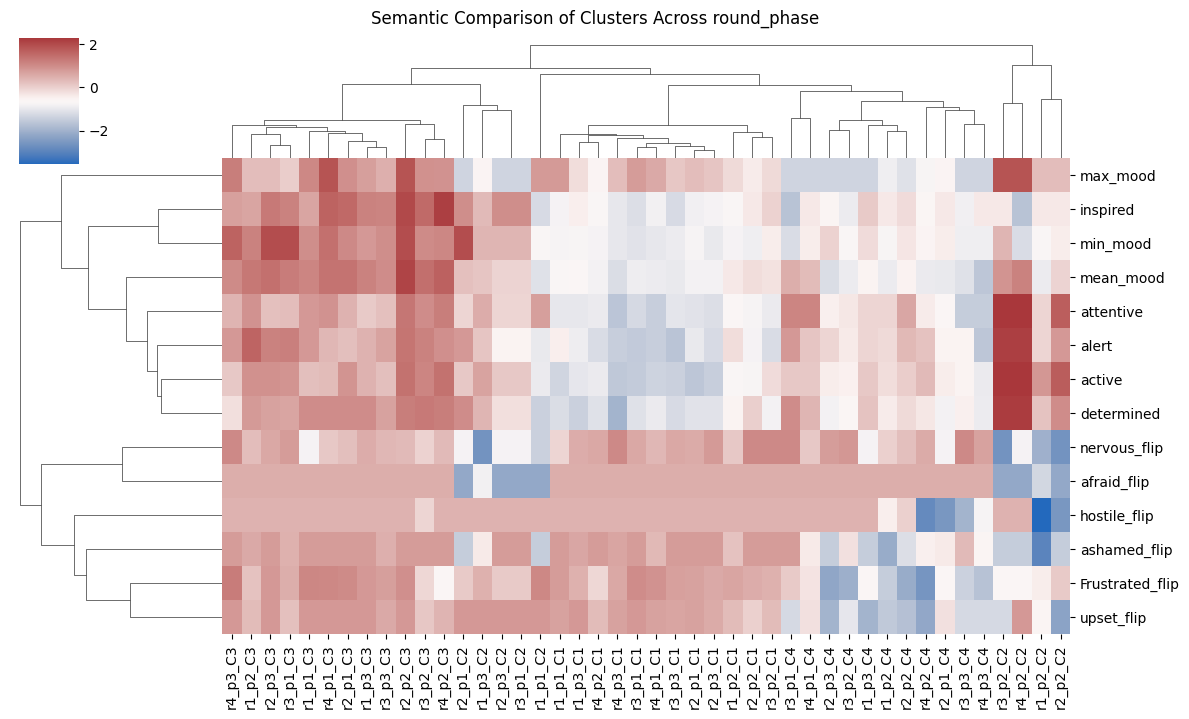

In [ ]:
cluster_profiles = (
    grouped_dfs
    .groupby([group_col_visualize, 'cluster'])[feat_cols_visualize]
    .mean()
    .reset_index()
)

# Set index to Group_Cluster label
cluster_num = [s.split(' ')[1] for s in cluster_profiles['cluster']]
cluster_profiles['label'] = cluster_profiles[group_col_visualize].astype(str) + '_C' + cluster_num
cluster_profiles.set_index('label', inplace=True)
cluster_profiles.index.name = None

# Optional: normalize for easier visual comparison
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(cluster_profiles[feat_cols_visualize])
scaled_df = pd.DataFrame(scaled_features, index=cluster_profiles.index, columns=feat_cols_visualize)
scaled_df = scaled_df.T
# Clustermap to show similarity between cluster profiles
g = sns.clustermap(scaled_df, cmap='vlag', standard_scale=None, figsize=(12, 7))

for i in range(scaled_df.shape[0]):
    for j in range(scaled_df.shape[1]):
        # Convert original data index to clustered index
        row = g.dendrogram_row.reordered_ind[i]
        col = g.dendrogram_col.reordered_ind[j]
        val = scaled_df.iloc[row, col]
        # g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.2f}', 
        #                   ha='center', va='center', color='black', fontsize=10)
plt.suptitle(f"Semantic Comparison of Clusters Across {group_col_visualize}", y=1.02)
plt.show()

In [ ]:
cluster_profiles

round_phase  cluster  Frustrated     upset   hostile     alert  \
r1_p1_C0       r1_p1        0    0.884615  1.038462  1.000000  2.307692   
r1_p2_C0       r1_p2        0    2.461538  1.538462  1.115385  2.884615   
r1_p3_C0       r1_p3        0    1.538462  1.153846  1.000000  2.115385   
r2_p1_C0       r2_p1        0    1.240000  1.080000  1.040000  2.000000   
r2_p2_C0       r2_p2        0    3.269231  1.846154  1.076923  2.653846   
r2_p3_C0       r2_p3        0    2.192308  1.384615  1.000000  1.961538   
r3_p1_C0       r3_p1        0    1.040000  1.120000  1.000000  1.920000   
r3_p2_C0       r3_p2        0    3.076923  1.538462  1.038462  2.615385   
r3_p3_C0       r3_p3        0    1.720000  1.280000  1.080000  1.880000   
r4_p1_C0       r4_p1        0    0.958333  1.083333  1.000000  1.750000   
r4_p2_C0       r4_p2        0    4.000000  1.730769  1.230769  2.653846   
r4_p3_C0       r4_p3        0    1.730769  1.230769  1.038462  1.615385   

           ashamed  inspired   nervous  attentive    afraid    active  \
r1_p1_C0  1.115385  1.961538  1.807692   2.846154  1.115385  2.153846   
r1_p2_C0  1.615385  2.307692  1.615385   3.307692  1.076923  3.230769   
r1_p3_C0  1.192308  2.346154  1.500000   2.653846  1.038462  2.538462   
r2_p1_C0  1.080000  2.200000  1.400000   2.560000  1.040000  2.200000   
r2_p2_C0  1.538462  2.423077  1.461538   3.538462  1.076923  3.153846   
r2_p3_C0  1.230769  2.000000  1.192308   2.423077  1.038462  2.153846   
r3_p1_C0  1.040000  1.920000  1.240000   2.480000  1.040000  2.240000   
r3_p2_C0  1.192308  2.538462  1.384615   3.307692  1.038462  3.269231   
r3_p3_C0  1.080000  1.960000  1.240000   2.440000  1.000000  2.240000   
r4_p1_C0  1.166667  2.125000  1.416667   2.500000  1.000000  2.125000   
r4_p2_C0  1.269231  2.576923  1.346154   3.269231  1.038462  3.461538   
r4_p3_C0  1.153846  1.846154  1.038462   2.038462  1.000000  1.846154   

          determined  
r1_p1_C0    2.730769  
r1_p2_C0    3.346154  
r1_p3_C0    2.807692  
r2_p1_C0    2.840000  
r2_p2_C0    3.384615  
r2_p3_C0    2.576923  
r3_p1_C0    2.760000  
r3_p2_C0    3.461538  
r3_p3_C0    2.800000  
r4_p1_C0    2.875000  
r4_p2_C0    3.384615  
r4_p3_C0    2.000000

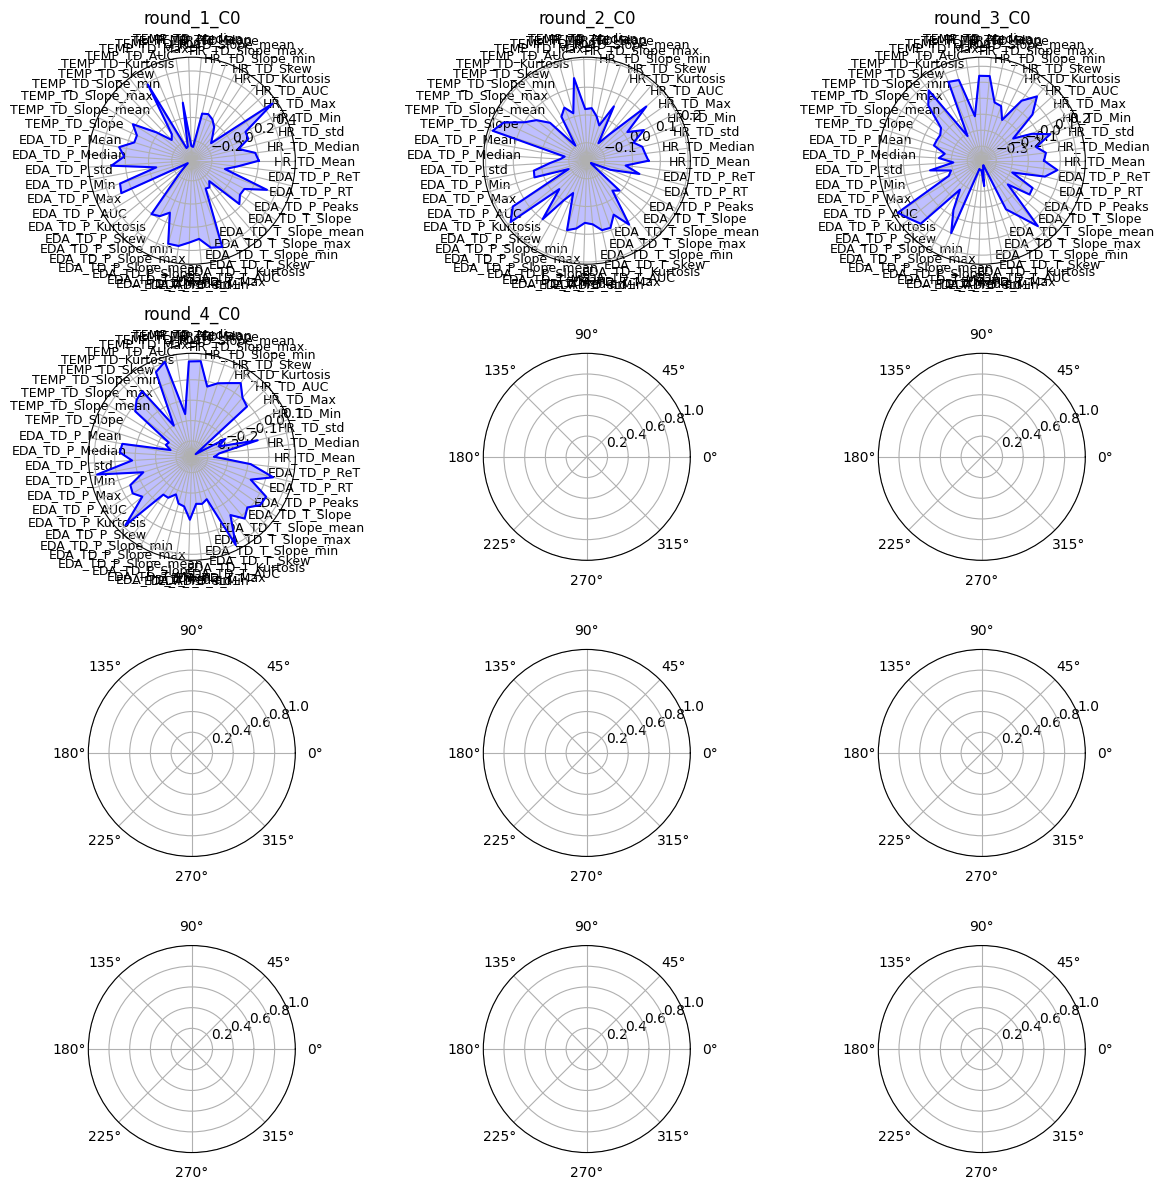

In [ ]:
num_cols = 3
num_rows = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12,12), subplot_kw={'projection': 'polar'})

for ax, cluster in zip(axs.reshape(-1), cluster_profiles.index):
    cluster_a = cluster_profiles.loc[cluster, :]#.values()

    angles = np.linspace(0, 2 * np.pi, len(feat_cols_visualize), endpoint=False).tolist()
    angles += angles[:1]  # to close the loop

    values_a = cluster_a[feat_cols_visualize].values.tolist() + [cluster_a[feat_cols_visualize].values.tolist()[0]]

    ax.plot(angles, values_a, label=cluster, color='blue')
    ax.fill(angles, values_a, alpha=0.25, color='blue')
    ax.set_thetagrids(np.degrees(angles[:-1]), feat_cols_visualize, fontsize=9)
    ax.set_title(f"{cluster}")
# plt.legend()
plt.tight_layout()
plt.show()

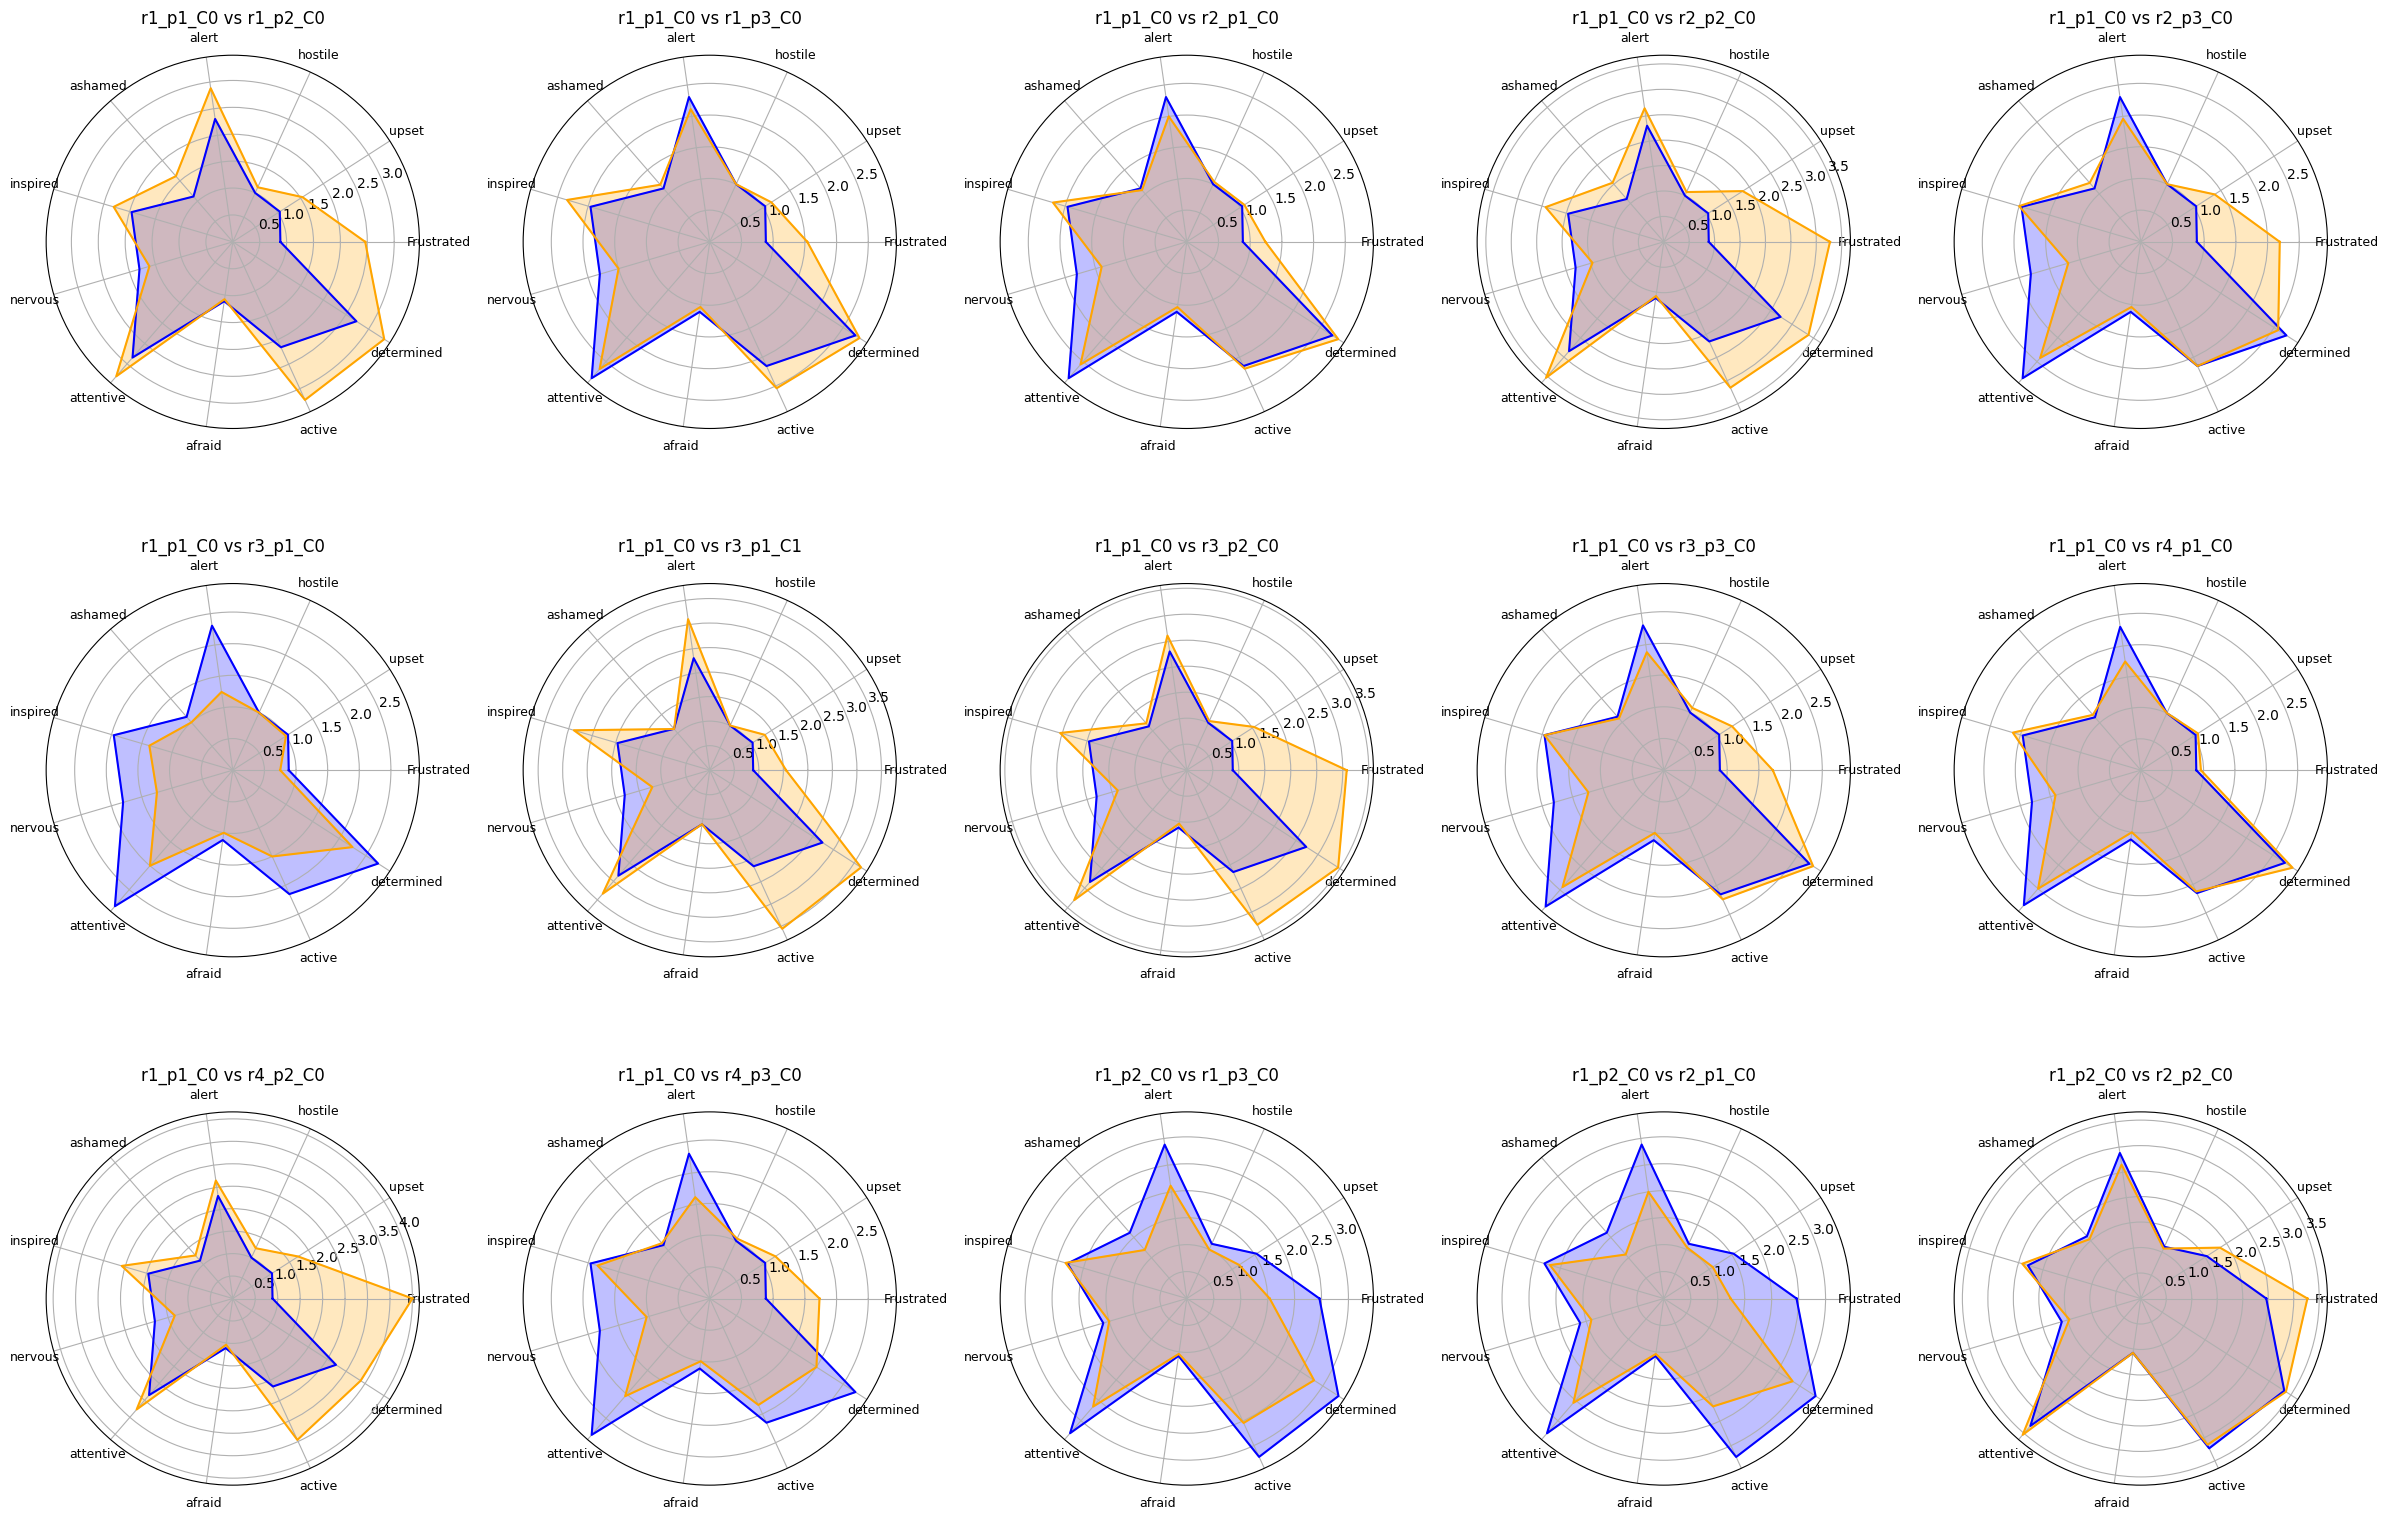

In [ ]:
from itertools import combinations
def plot_radar(ax, cluster_a, cluster_b, features, label_a, label_b):
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]  # to close the loop

    values_a = cluster_a[features].values.tolist() + [cluster_a[features].values.tolist()[0]]
    values_b = cluster_b[features].values.tolist() + [cluster_b[features].values.tolist()[0]]

    ax.plot(angles, values_a, label=label_a, color='blue')
    ax.plot(angles, values_b, label=label_b, color='orange')
    ax.fill(angles, values_a, alpha=0.25, color='blue')
    ax.fill(angles, values_b, alpha=0.25, color='orange')
    ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
    ax.set_title(f"{label_a} vs {label_b}")
    # plt.legend()
    # plt.show()

# unique_group_names = cluster_profiles[group_col].unique()
# unique_clusters = cluster_profiles['cluster'].unique()

num_plots = math.comb(12,2)
num_cols = 5
num_rows = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(24,16), subplot_kw={'projection': 'polar'})

for ax, (cluster1, cluster2) in zip(axs.reshape(-1), combinations(cluster_profiles.index, 2)):
    cluster_a = cluster_profiles.loc[cluster1, :]#.values()
    cluster_b = cluster_profiles.loc[cluster2, :]#.values()

    plot_radar(ax, cluster_a, cluster_b, feat_cols_visualize, f"{cluster1}", f"{cluster2}")
# plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
Data[group_col].unique().shape, cluster_profiles_pca.shape

((4,), (4, 2))

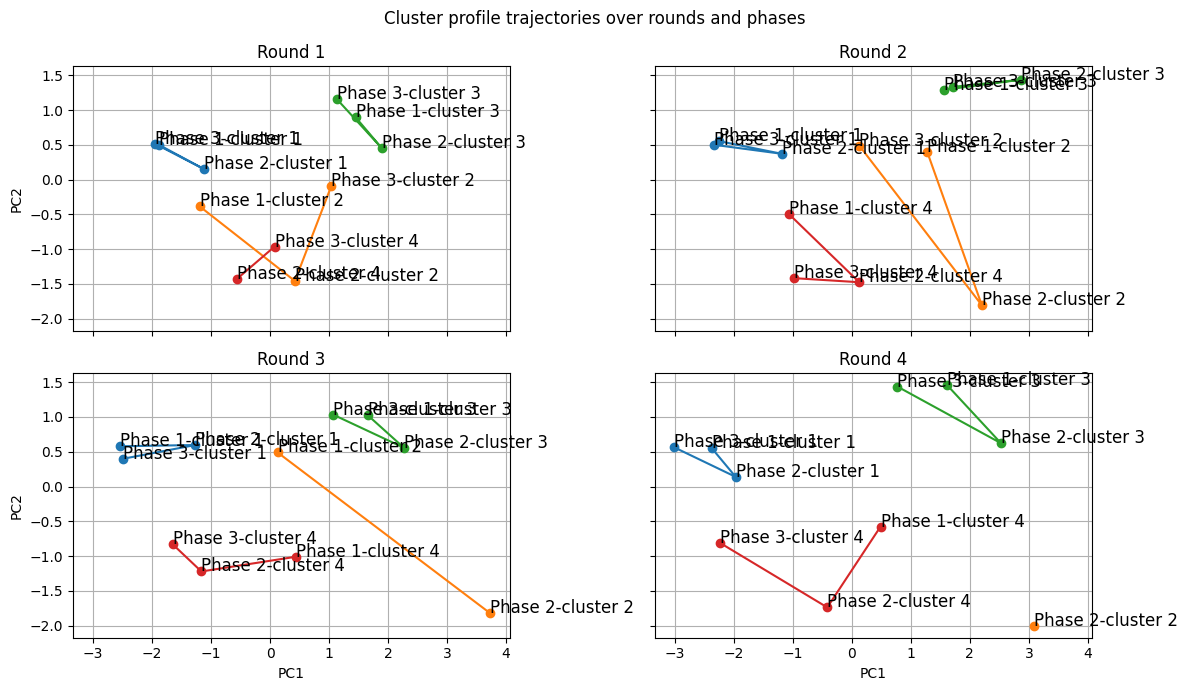

In [ ]:
cluster_profiles['round'] = ['Round ' + rp.split('_')[0][-1] for rp in cluster_profiles['round_phase'].values]
cluster_profiles['phase'] = ['Phase ' + rp.split('_')[1][-1] for rp in cluster_profiles['round_phase'].values]

# Assume df_profiles is the DataFrame of cluster profiles
# X = cluster_profiles[[f'feature_{i}' for i in range(len(feat_cols_pca))]]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(cluster_profiles[feat_cols_pca])

cluster_profiles['PC1'] = X_pca[:, 0]
cluster_profiles['PC2'] = X_pca[:, 1]
selected_rounds = ['Round 1', 'Round 2', 'Round 3', 'Round 4']

set_xlabel = [False, False, True, True]
set_ylabel = [True, False, True, False]
# selected_rounds = selected_rounds[1:2]
# plt.figure(figsize=(12,12))
fig, axs = plt.subplots(2,2, figsize=(12,7), sharex=True, sharey=True)
for k, (ax, sel_rounds) in enumerate(zip(axs.reshape(-1), selected_rounds)):
    for round_id, group in cluster_profiles[cluster_profiles['round'].isin([sel_rounds])].groupby(['round', 'cluster']):
        ax.plot(group['PC1'], group['PC2'], marker='o', label=f'{round_id}')
        for i, row in group.iterrows():
            ax.text(row['PC1'], row['PC2'], f"{row['phase']}-{row['cluster']}", fontsize=12)
            
    ax.set_title(sel_rounds)
    if set_xlabel[k]: ax.set_xlabel('PC1')
    if set_ylabel[k]: ax.set_ylabel('PC2')
    ax.grid(True)
    # ax.set_aspect('equal')
            
# fig.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
plt.suptitle("Cluster profile trajectories over rounds and phases")
# fig.supxlabel("PC1")
# fig.supylabel("PC2")
plt.tight_layout()
plt.show()


In [ ]:
cluster_profiles[cluster_profiles['round'].isin(selected_rounds)]

Empty DataFrame
Columns: [round_phase, cluster, Frustrated_flip, upset_flip, hostile_flip, alert, ashamed_flip, inspired, nervous_flip, attentive, afraid_flip, active, determined, mean_mood, min_mood, max_mood, round, phase, PC1, PC2]
Index: []

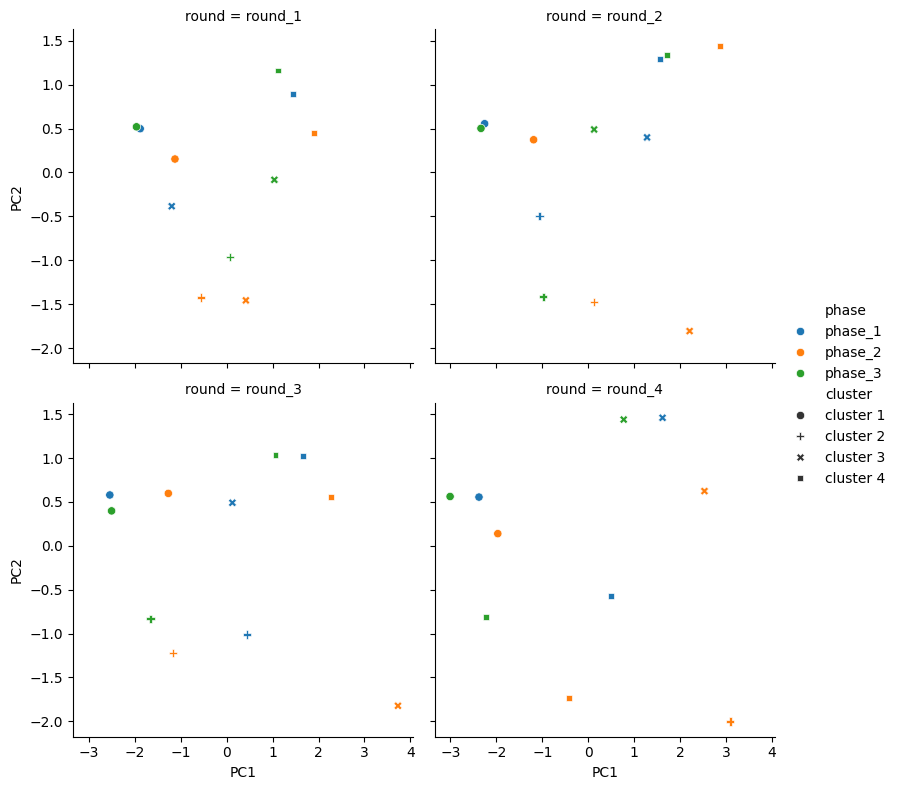

In [ ]:
g = sns.FacetGrid(cluster_profiles, col="round", col_wrap=2, height=4)
g.map_dataframe(sns.scatterplot, x="PC1", y="PC2", hue="phase", style="cluster")
g.add_legend()

In [ ]:
cluster_profiles

round_phase    cluster  Frustrated_flip  upset_flip  hostile_flip  \
r1_p1_C1       r1_p1  cluster 1         4.466667    3.933333      4.000000   
r1_p1_C2       r1_p1  cluster 2         4.666667    4.000000      4.000000   
r1_p1_C3       r1_p1  cluster 3         4.687500    4.000000      4.000000   
r1_p2_C1       r1_p2  cluster 1         4.375000    3.750000      4.000000   
r1_p2_C2       r1_p2  cluster 2         3.666667    3.333333      3.333333   
r1_p2_C3       r1_p2  cluster 3         4.083333    3.750000      4.000000   
r1_p2_C4       r1_p2  cluster 4         2.928571    2.857143      3.857143   
r1_p3_C1       r1_p3  cluster 1         4.250000    4.000000      4.000000   
r1_p3_C2       r1_p3  cluster 2         4.250000    4.000000      4.000000   
r1_p3_C3       r1_p3  cluster 3         4.500000    4.000000      4.000000   
r1_p3_C4       r1_p3  cluster 4         3.500000    2.666667      4.000000   
r2_p1_C1       r2_p1  cluster 1         4.400000    3.933333      4.000000   
r2_p1_C2       r2_p1  cluster 2         4.000000    4.000000      4.000000   
r2_p1_C3       r2_p1  cluster 3         4.642857    4.000000      4.000000   
r2_p1_C4       r2_p1  cluster 4         3.500000    3.500000      3.500000   
r2_p2_C1       r2_p2  cluster 1         4.300000    3.600000      4.000000   
r2_p2_C2       r2_p2  cluster 2         4.000000    2.500000      3.500000   
r2_p2_C3       r2_p2  cluster 3         4.600000    4.000000      4.000000   
r2_p2_C4       r2_p2  cluster 4         2.500000    2.785714      3.928571   
r2_p3_C1       r2_p3  cluster 1         4.333333    3.866667      4.000000   
r2_p3_C2       r2_p3  cluster 2         4.000000    4.000000      4.000000   
r2_p3_C3       r2_p3  cluster 3         4.500000    4.000000      4.000000   
r2_p3_C4       r2_p3  cluster 4         2.416667    2.666667      4.000000   
r3_p1_C1       r3_p1  cluster 1         4.625000    4.000000      4.000000   
r3_p1_C2       r3_p1  cluster 2         4.000000    4.000000      4.000000   
r3_p1_C3       r3_p1  cluster 3         4.285714    3.714286      4.000000   
r3_p1_C4       r3_p1  cluster 4         4.000000    3.000000      4.000000   
r3_p2_C1       r3_p2  cluster 1         4.250000    3.750000      4.000000   
r3_p2_C2       r3_p2  cluster 2         3.500000    3.000000      4.000000   
r3_p2_C3       r3_p2  cluster 3         3.875000    3.666667      3.916667   
r3_p2_C4       r3_p2  cluster 4         2.555556    3.111111      4.000000   
r3_p3_C1       r3_p3  cluster 1         4.416667    3.916667      4.000000   
r3_p3_C3       r3_p3  cluster 3         4.437500    3.875000      4.000000   
r3_p3_C4       r3_p3  cluster 4         3.000000    3.000000      3.600000   
r4_p1_C1       r4_p1  cluster 1         4.562500    3.937500      4.000000   
r4_p1_C3       r4_p1  cluster 3         4.666667    4.000000      4.000000   
r4_p1_C4       r4_p1  cluster 4         3.750000    3.500000      4.000000   
r4_p2_C1       r4_p2  cluster 1         3.875000    3.750000      4.000000   
r4_p2_C2       r4_p2  cluster 2         3.500000    4.000000      4.000000   
r4_p2_C3       r4_p2  cluster 3         3.500000    3.800000      4.000000   
r4_p2_C4       r4_p2  cluster 4         2.181818    2.545455      3.454545   
r4_p3_C1       r4_p3  cluster 1         4.343750    3.937500      4.000000   
r4_p3_C3       r4_p3  cluster 3         4.800000    4.000000      4.000000   
r4_p3_C4       r4_p3  cluster 4         2.800000    3.000000      3.800000   

             alert  ashamed_flip  inspired  nervous_flip  attentive  \
r1_p1_C1  2.066667      4.000000  1.666667      3.400000   2.200000   
r1_p1_C2  1.666667      3.000000  1.333333      2.666667   3.666667   
r1_p1_C3  3.000000      4.000000  2.750000      3.000000   3.750000   
r1_p2_C1  2.250000      3.750000  1.750000      3.500000   2.500000   
r1_p2_C2  2.333333      2.333333  2.000000      2.333333   3.000000   
r1_p2_C3  3.583333      3.916667  2.750000      3.583333   3.833333   
r

In [ ]:
from scipy.spatial.distance import euclidean

def compute_phase_differences(df):
    diffs = []
    for round_id, group in df.groupby('round'):
        group = group.sort_values('phase')
        for (p1, p2) in zip(group.index[:-1], group.index[1:]):
            d = euclidean(group.loc[p1, feat_cols_visualize], group.loc[p2, feat_cols_visualize])
            diffs.append({'round': round_id, 'phase1': group.loc[p1, 'phase'],
                          'phase2': group.loc[p2, 'phase'], 'distance': d})
    return pd.DataFrame(diffs)

distances_df = compute_phase_differences(cluster_profiles)
distances_df

round   phase1   phase2  distance
0   round_1  phase_1  phase_1  2.276216
1   round_1  phase_1  phase_1  3.582165
2   round_1  phase_1  phase_2  2.752523
3   round_1  phase_2  phase_2  2.768001
4   round_1  phase_2  phase_2  3.213800
5   round_1  phase_2  phase_2  3.282983
6   round_1  phase_2  phase_3  2.642845
7   round_1  phase_3  phase_3  3.359825
8   round_1  phase_3  phase_3  2.176262
9   round_1  phase_3  phase_3  2.600558
10  round_2  phase_1  phase_1  4.016661
11  round_2  phase_1  phase_1  2.189670
12  round_2  phase_1  phase_1  3.326091
13  round_2  phase_1  phase_2  1.716648
14  round_2  phase_2  phase_2  4.411583
15  round_2  phase_2  phase_2  3.750857
16  round_2  phase_2  phase_2  4.112512
17  round_2  phase_2  phase_3  3.490813
18  round_2  phase_3  phase_3  2.922708
19  round_2  phase_3  phase_3  2.474874
20  round_2  phase_3  phase_3  4.004453
21  round_3  phase_1  phase_1  3.219567
22  round_3  phase_1  phase_1  2.464249
23  round_3  phase_1  phase_1  3.264859
24  round_3  phase_1  phase_2  3.204001
25  round_3  phase_2  phase_2  5.753469
26  round_3  phase_2  phase_2  3.220889
27  round_3  phase_2  phase_2  3.943080
28  round_3  phase_2  phase_3  2.621808
29  round_3  phase_3  phase_3  3.761285
30  round_3  phase_3  phase_3  3.460908
31  round_4  phase_1  phase_1  4.204237
32  round_4  phase_1  phase_1  2.534269
33  round_4  phase_1  phase_2  2.709935
34  round_4  phase_2  phase_2  5.897257
35  round_4  phase_2  phase_2  3.991533
36  round_4  phase_2  phase_2  3.912329
37  round_4  phase_2  phase_3  3.868201
38  round_4  phase_3  phase_3  3.956829
39  round_4  phase_3  phase_3  4.151351

In [ ]:
cluster_profiles

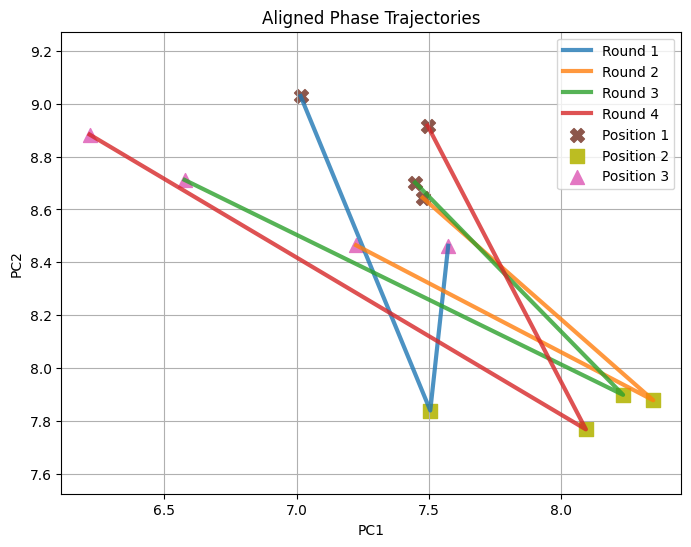

In [ ]:
cluster_profiles_pca = np.stack(cluster_profiles.groupby(group_col_visualize).apply(
    lambda row: dim_reduction_model.transform(row[feat_cols_pca].values).mean(axis=0), include_groups=False).values, axis=0)
# Marker styles for each position in the group (0, 1, 2)
marker_styles = ["X", "s", "^"]  # cross, square, triangle
colors_marker = ['tab:brown', 'tab:olive', 'tab:pink']

plt.figure(figsize=(8, 6))

# 1. Connect each group of 3 points
for i in range(0, cluster_profiles_pca.shape[0], 3):
    group_x = cluster_profiles_pca[i:i+3, 0]
    group_y = cluster_profiles_pca[i:i+3, 1]
    plt.plot(group_x, group_y, '-', alpha=0.8, label=f"Round {(i//3)+1}", linewidth=3)

# 2. Plot points by column (position in the group)
for col in range(3):
    col_indices = list(range(col, cluster_profiles_pca.shape[0], 3))
    col_x = [cluster_profiles_pca[:,0][i] for i in col_indices]
    col_y = [cluster_profiles_pca[:,1][i] for i in col_indices]
    plt.scatter(col_x, col_y, marker=marker_styles[col], s=100, label=f'Position {col+1}', color=colors_marker[col])

plt.title("Aligned Phase Trajectories")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
1 // 3

0

In [ ]:
cluster_profiles_pca.shape

(12, 2)

In [ ]:
grouped_dfs['round_phase'].unique()

array(['r1_p1', 'r1_p2', 'r1_p3', 'r2_p1', 'r2_p2', 'r2_p3', 'r3_p1',
       'r3_p2', 'r3_p3', 'r4_p1', 'r4_p2', 'r4_p3'], dtype=object)

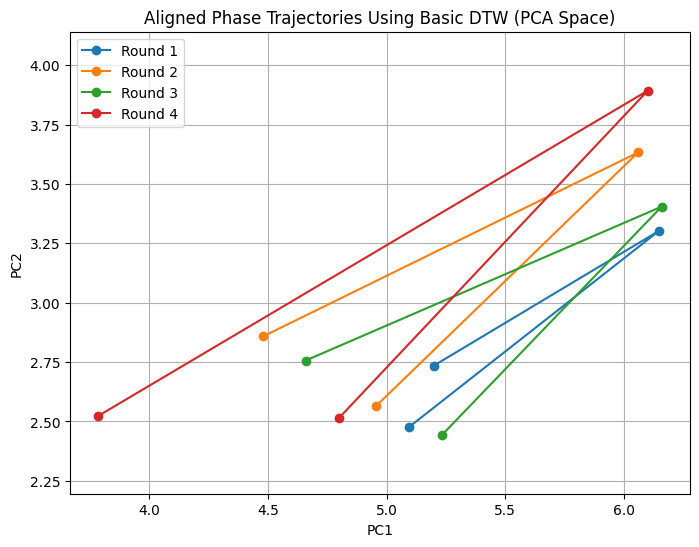

In [ ]:
df_sum = pd.DataFrame({
    'round': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    'phase': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
    'PC1': cluster_profiles_pca[:, 0],
    'PC2': cluster_profiles_pca[:, 1]
})
round_trajectories = {
    r: df[df['round'] == r].sort_values('phase')[['PC1', 'PC2']].values
    for r, df in df_sum.groupby('round')
}

from scipy.spatial.distance import euclidean

def dtw_basic(seq1, seq2):
    n, m = len(seq1), len(seq2)
    cost = np.full((n+1, m+1), np.inf)
    cost[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            dist = euclidean(seq1[i-1], seq2[j-1])
            cost[i, j] = dist + min(cost[i-1, j], cost[i, j-1], cost[i-1, j-1])

    # Backtrack to find the optimal path
    i, j = n, m
    path = []
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        steps = [(i-1, j), (i, j-1), (i-1, j-1)]
        i, j = min(steps, key=lambda x: cost[x[0], x[1]])

    path.reverse()
    return path

ref_round = 1
ref_traj = round_trajectories[ref_round]
aligned_trajectories = {ref_round: ref_traj}

for r, traj in round_trajectories.items():
    if r == ref_round:
        continue
    path = dtw_basic(ref_traj, traj)
    aligned = np.array([traj[j] for i, j in path])  # warp `traj` to match `ref`
    aligned_trajectories[r] = aligned

import matplotlib.pyplot as plt

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(8, 6))

for r, traj in aligned_trajectories.items():
    plt.plot(traj[:, 0], traj[:, 1], '-o', label=f'Round {r}', color=colors[r - 1])

plt.title("Aligned Phase Trajectories Using Basic DTW (PCA Space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


